In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install pytesseract

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

**Extracting Bounding Box Coordinates from XML Annotations for Object Detection**

In [4]:
path = glob('/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images/*.xml')

# Initializing a dictionary to store file paths and bounding box coordinates
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])

# Iterating over each XML file in the specified path
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')# Locating the object element in the XML (contains bounding box info)
    labels_info = member_object.find('bndbox')# Extracting the bounding box (bndbox) element

    # Extracting the bounding box coordinates and converting them to integers
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # Appending extracted information to the dictionary
    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

**Saving Extracted Bounding Box Coordinates to CSV**

In [6]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,/content/drive/MyDrive/DIP/PlateTracker/PlateT...,285,374,185,226
1,/content/drive/MyDrive/DIP/PlateTracker/PlateT...,201,217,185,195
2,/content/drive/MyDrive/DIP/PlateTracker/PlateT...,72,196,139,222
3,/content/drive/MyDrive/DIP/PlateTracker/PlateT...,296,332,189,209
4,/content/drive/MyDrive/DIP/PlateTracker/PlateT...,181,269,264,289



**Extracting Full Image File Path from XML Annotation**

In [7]:
filename = df['filepath'][0]

# Defining a function to extract and construct the full image file path from the XML file
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text# Parsing the XML file to extract its contents
    filepath_image = os.path.join('/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images',filename_image)
    return filepath_image
getFilename(filename)

'/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images/Cars406.png'

In [8]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images/Cars406.png',
 '/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images/Cars352.png',
 '/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images/Cars398.png',
 '/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images/Cars403.png',
 '/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images/Cars396.png',
 '/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images/Cars363.png',
 '/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images/Cars364.png',
 '/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images/Cars368.png',
 '/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images/Cars332.png',
 '/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images/Cars320.png']

In [9]:
image_path[99]

'/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/images/Cars289.png'

In [10]:
df[99:101]

,filepath,xmin,xmax,ymin,ymax
99,/content/drive/MyDrive/DIP/PlateTracker/PlateT...,163,271,140,173
100,/content/drive/MyDrive/DIP/PlateTracker/PlateT...,541,598,366,384


**Displaying Image with Bounding Box Using Plotly**

In [11]:
# Load the image using only one method
file_path = image_path[99]

# Read the image with `io.imread`
img = io.imread(file_path)

# Displaying the image with Plotly
fig = px.imshow(img)
fig.update_layout(
    width=600,
    height=500,
    margin=dict(l=10, r=10, b=10, t=10),
    xaxis_title='Figure 8 - N2.jpeg with bounding box')

# Adding bounding box
fig.add_shape(
    type='rect',
    x0=163, x1=271, y0=140, y1=173,
    xref='x', yref='y',
    line=dict(color='red', width=3))

''' fig.add_annotation(
    x=572,  # X-coordinate near the box
    y=461,  # Y-coordinate near the box
    text="Plate",
    showarrow=False,
    font=dict(size=20, color="black"),  # Customize font size and color
    bgcolor="white",  # Optional background color for better visibility
    opacity=0.7  # Optional transparency
) '''

fig.show()

**Preprocessing Image Data and Normalizing Bounding Box Coordinates for Object Detection**

In [12]:
# Extracting all columns except the first one from the DataFrame and storing them as a NumPy array
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)# Reading the image from the file using OpenCV
    h,w,d = img_arr.shape
    # --- Preprocessing the image ---
    load_image = load_img(image,target_size=(224,224))# Resizing the image to 224x224 using Keras's `load_img` function
    load_image_arr = img_to_array(load_image)# Converting the PIL image to a NumPy array
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # --- Normalizing the bounding box coordinates ---
    # Extracting the bounding box values for the current image from the `labels` array
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [13]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [14]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((526, 224, 224, 3), (132, 224, 224, 3), (526, 4), (132, 4))

**Building a Custom Model with InceptionResNetV2 for Object Detection**

In [15]:
# Load the InceptionResNetV2 model with pretrained weights from ImageNet
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
# Output of the base model
headmodel = inception_resnet.output

headmodel = Flatten()(headmodel)

headmodel = Dense(500,activation="relu")(headmodel)# Adding a fully connected (dense) layer with 500 neurons and ReLU activation
headmodel = Dense(250,activation="relu")(headmodel)# Adding another dense layer with 250 neurons and ReLU activation
headmodel = Dense(4,activation='sigmoid')(headmodel)# Adding the final dense layer with 4 neurons (for bounding box coordinates: xmin, xmax, ymin, ymax)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [18]:
# Complie model
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 73,663,490 (281.00 MB)

 Trainable params: 73,602,946 (280.77 MB)

 Non-trainable params: 60,544 (236.50 KB)

**Training the Model with TensorBoard Callback for Object Detection**

In [19]:
tfb = TensorBoard('object_detection')# Logs will be saved in the 'object_detection' directory
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=100,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.5252 - loss: 0.0437 - val_accuracy: 0.7348 - val_loss: 0.0219
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 212ms/step - accuracy: 0.7454 - loss: 0.0092 - val_accuracy: 0.7273 - val_loss: 0.0169
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.8500 - loss: 0.0046 - val_accuracy: 0.8258 - val_loss: 0.0195
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.8707 - loss: 0.0031 - val_accuracy: 0.8182 - val_loss: 0.0168
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - accuracy: 0.8779 - loss: 0.0026 - val_accuracy: 0.8864 - val_loss: 0.0142
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.9127 - loss: 0.0028 - val_accuracy: 0.8788 - val_loss: 0.0120
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.9229 - loss: 0.0018 - val_accuracy: 0.8712 - val_loss: 0.0133
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.9320 - loss: 0.0012 - va

**Plotting Training and Validation Loss Over Epochs**

In [21]:
model.save('./object_detection.keras')

In [29]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Overall Test Accuracy: {test_accuracy:.4f}")

Overall Test Accuracy: 0.9318


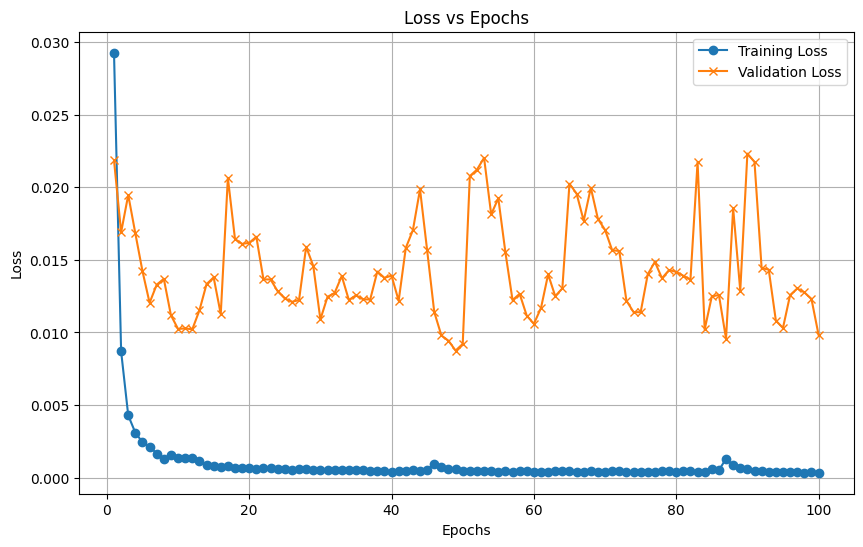

In [20]:
import matplotlib.pyplot as plt

# Extract training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array for epoch numbers (from 1 to number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plot the loss values for training and validation
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

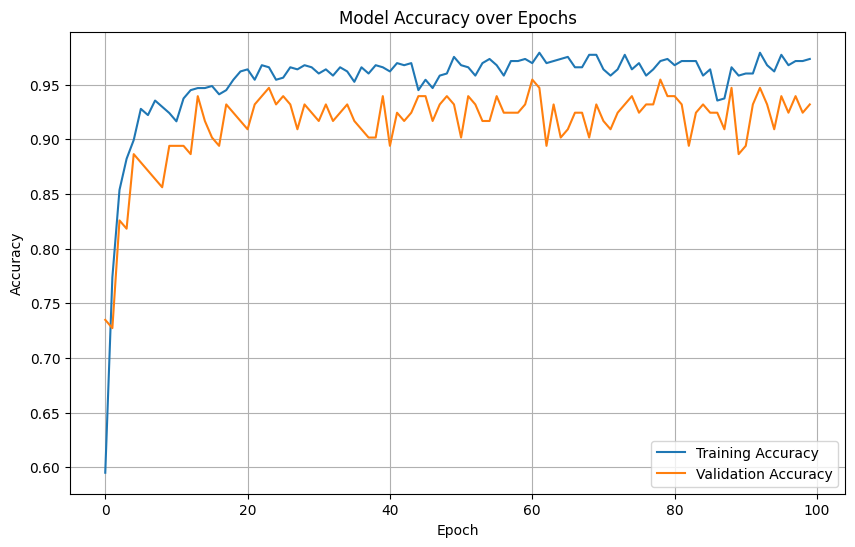

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/Plate_Tracker.keras')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [31]:
# Create pipeline
path = '/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/TEST/Red_car.jpeg'
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
(100, 73) (162, 87)


In [32]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]# Crop the region of interest (ROI) from the image using the bounding box coordinates
fig = px.imshow(roi)# Display the cropped region (ROI) interactively using Plotly
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Plate')

In [34]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,849 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [35]:
def extract_text_from_roi(roi):
    try:
        # Convert NumPy array to PIL Image if needed
        if isinstance(roi, np.ndarray):
            roi = img[ymin:ymax,xmin:xmax]

        # Extract text with additional configuration for better accuracy
        text = pt.image_to_string(
            roi,
            config='--psm 6 --oem 3',  # Page Segmentation Mode and OCR Engine Mode
            lang='eng'  # Specify language if needed
        )
        return text.strip()
    except Exception as e:
        print(f"Error in text extraction: {e}")
        return ""

# Use the function
text = extract_text_from_roi(roi)
print("Extracted Text:", text)


Extracted Text: LRSS TEER


Loading image...
Detecting license plate...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Preprocessing license plate...
Extracting text...
Displaying results...


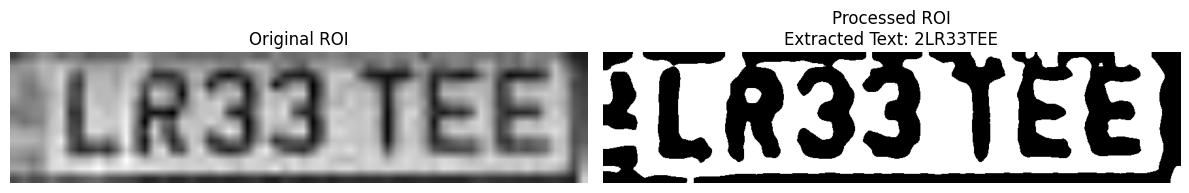


Detected License Plate Number: 2LR33TEE


In [36]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pytesseract
import warnings
warnings.filterwarnings('ignore')

def preprocess_plate(roi):
    """
    Preprocess the detected license plate ROI
    """
    try:
        # Convert to grayscale if RGB
        if len(roi.shape) == 3:
            gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
        else:
            gray = roi.copy()

        # Resize to larger dimension for better OCR
        height = 200
        aspect_ratio = gray.shape[1] / gray.shape[0]
        width = int(height * aspect_ratio)
        resized = cv2.resize(gray, (width, height))

        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        contrast_enhanced = clahe.apply(resized)

        # Noise reduction
        denoised = cv2.bilateralFilter(contrast_enhanced, 11, 17, 17)

        # Thresholding
        _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Remove small noise
        kernel = np.ones((3,3), np.uint8)
        morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

        return morph, resized

    except Exception as e:
        print(f"Error in plate preprocessing: {str(e)}")
        return None, None

def extract_text(processed_roi):
    """
    Extract text from the preprocessed ROI
    """
    try:
        # Configure pytesseract
        custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

        # Extract text
        text = pytesseract.image_to_string(processed_roi, config=custom_config)

        # Clean text
        text = ''.join(c for c in text if c.isalnum())

        return text

    except Exception as e:
        print(f"Error in text extraction: {str(e)}")
        return ""

def display_results(original_roi, processed_roi, extracted_text):
    """
    Display original ROI, processed ROI, and extracted text
    """
    plt.figure(figsize=(12, 4))

    # Original ROI
    plt.subplot(1, 2, 1)
    if len(original_roi.shape) == 3:
        plt.imshow(original_roi)
    else:
        plt.imshow(original_roi, cmap='gray')
    plt.title('Original ROI')
    plt.axis('off')

    # Processed ROI
    plt.subplot(1, 2, 2)
    plt.imshow(processed_roi, cmap='gray')
    plt.title(f'Processed ROI\nExtracted Text: {extracted_text}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def process_license_plate(path):
    """
    Main pipeline for license plate preprocessing and text extraction
    """
    try:
        # Load and prepare image
        print("Loading image...")
        image = load_img(path)
        image = np.array(image, dtype=np.uint8)

        # Prepare for model
        image_for_model = Image.fromarray(image)
        image_for_model = image_for_model.resize((224, 224))
        image_arr = img_to_array(image_for_model)/255.0
        h, w = image.shape[:2]
        test_arr = image_arr.reshape(1, 224, 224, 3)

        # Get predictions
        print("Detecting license plate...")
        coords = model.predict(test_arr)

        # Denormalize coordinates
        denorm = np.array([w, w, h, h])
        coords = coords * denorm
        coords = coords.astype(np.int32)

        # Extract ROI
        xmin, xmax, ymin, ymax = coords[0]
        roi = image[ymin:ymax, xmin:xmax]

        # Preprocess ROI
        print("Preprocessing license plate...")
        processed_roi, resized_original = preprocess_plate(roi)

        if processed_roi is not None:
            # Extract text
            print("Extracting text...")
            plate_text = extract_text(processed_roi)

            # Display results
            print("Displaying results...")
            display_results(resized_original, processed_roi, plate_text)

            return plate_text
        else:
            print("Preprocessing failed!")
            return None

    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        return None

# Main execution
if __name__ == "__main__":
    try:
        # Replace with your image path
        path = '/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/TEST/Red_car.jpeg'

        # Process the license plate
        plate_text = process_license_plate(path)

        if plate_text:
            print(f"\nDetected License Plate Number: {plate_text}")
        else:
            print("\nFailed to extract license plate text. Please check the error messages above.")

    except Exception as e:
        print(f"Error running pipeline: {str(e)}")